# Prediction of bitcoin price using LSTM network for several steps in future



Library instalation on and importatiing of all necessary libribraries for this project

In [37]:
%pip install ccxt
%pip install pandas
%pip install torch
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install mplfinance
%pip install ta

import ccxt

import pandas as pd
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# GPU CUDA activation if possible


In [38]:

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    # Get number of devices
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}")
    
    # Get list of devices
    device_list = [i for i in range(torch.cuda.device_count())]
    print("CUDA devices available:", device_list)
    device = 'cuda'
else:
    print("No CUDA devices available.")
    device = "cpu"


CUDA is available: True
Number of CUDA devices: 1
CUDA devices available: [0]


# Real BTC data loading from binance.

In [39]:


# Function to fetch historical data
def load_data(symbol, timeframe, limit, since_date):
    exchange = ccxt.binance()

    def fetch_data(symbol, timeframe, since, limit):
        all_data = []
        while since < exchange.milliseconds():
            data = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if len(data) == 0:
                break
            since = data[-1][0] + 1
            print("Fetched", len(data), "candles")
            all_data += data
        return all_data

    
    # Get data for the last period starting from since_date till now
    since = exchange.parse8601(since_date)
    data = fetch_data(symbol, timeframe, since, limit)
    print("Fetched total", len(data), "candles")

    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

 

    # Prepare data for LSTM using scale between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

    
    return df,scaler


# Start of processing. Data loading with 1h step (candle) for the last 2 month

In [40]:
symbol = 'BTC/USDT'
timeframe = '1h'
limit = 100  # Number of candles to fetch per request
since_date = '2024-12-01T00:00:00Z'  # Start date for fetching data



df, scaler = load_data(symbol, timeframe, limit, since_date=since_date)

Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles
Fetched 100 candles


# Function for creating of data sequences for LSTM network. 


In [41]:

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


# LSTM network data train set preparation

In [42]:
test_seq_length = 6 # Sequence length for testing

X, y = create_sequences(df['close'].values, test_seq_length)
print(X.shape, y.shape)

X_train = torch.from_numpy(X).to(device=device).float()
y_train = torch.from_numpy(y).to(device=device).float()




(9020, 6) (9020,)


# LSTM strucructure 

In [43]:

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


# Model training 

In [ ]:
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq).to(device)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if single_loss.item() < 0.0001:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')  #overfitting protection
        break
    if i % 10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


/home/arsatyants/tradingAnalytics/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00163155
epoch:  10 loss: 0.00115705
epoch:  20 loss: 0.00066462
epoch:  30 loss: 0.00039736
epoch:  40 loss: 0.00030366
epoch:  50 loss: 0.00025768
epoch:  60 loss: 0.00029242



# PREDICTIONS

In [ ]:

# Make predictions
m = model.eval()
print(m)


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:

# Predict for 3 steps
future_steps = 3


test_inputs = df['close'][-test_seq_length:].values.tolist()
print(test_inputs)


for _ in range(future_steps):
    seq = torch.FloatTensor(test_inputs[-test_seq_length:]).to(device)
    print(seq)
    with torch.no_grad():
        m.hidden_cell = (torch.zeros(1, 1, m.hidden_layer_size).to(device),
                         torch.zeros(1, 1, m.hidden_layer_size).to(device))
        test_inputs.append(m(seq).item())

print("--",test_inputs[-future_steps:])

predicted_future_prices = scaler.inverse_transform(np.array(test_inputs[-future_steps:]).reshape(-1, 1))


[-0.37385024600023753, -0.3366175030765892, -0.2950012665726187, -0.3147816739344038, -0.30847791173521966, -0.3455618299347454]
tensor([-0.3739, -0.3366, -0.2950, -0.3148, -0.3085, -0.3456], device='cuda:0')
tensor([-0.3366, -0.2950, -0.3148, -0.3085, -0.3456, -0.3818], device='cuda:0')
tensor([-0.2950, -0.3148, -0.3085, -0.3456, -0.3818, -0.4045], device='cuda:0')
-- [-0.3818362057209015, -0.40449079871177673, -0.41207197308540344]


# PREDICTED PRICES FOR NEXT 3 HOURS

In [ ]:

print(predicted_future_prices)

[[90635.36475936]
 [90055.39392586]
 [89861.31142691]]


# PLOT of the results on common on graph for visualization

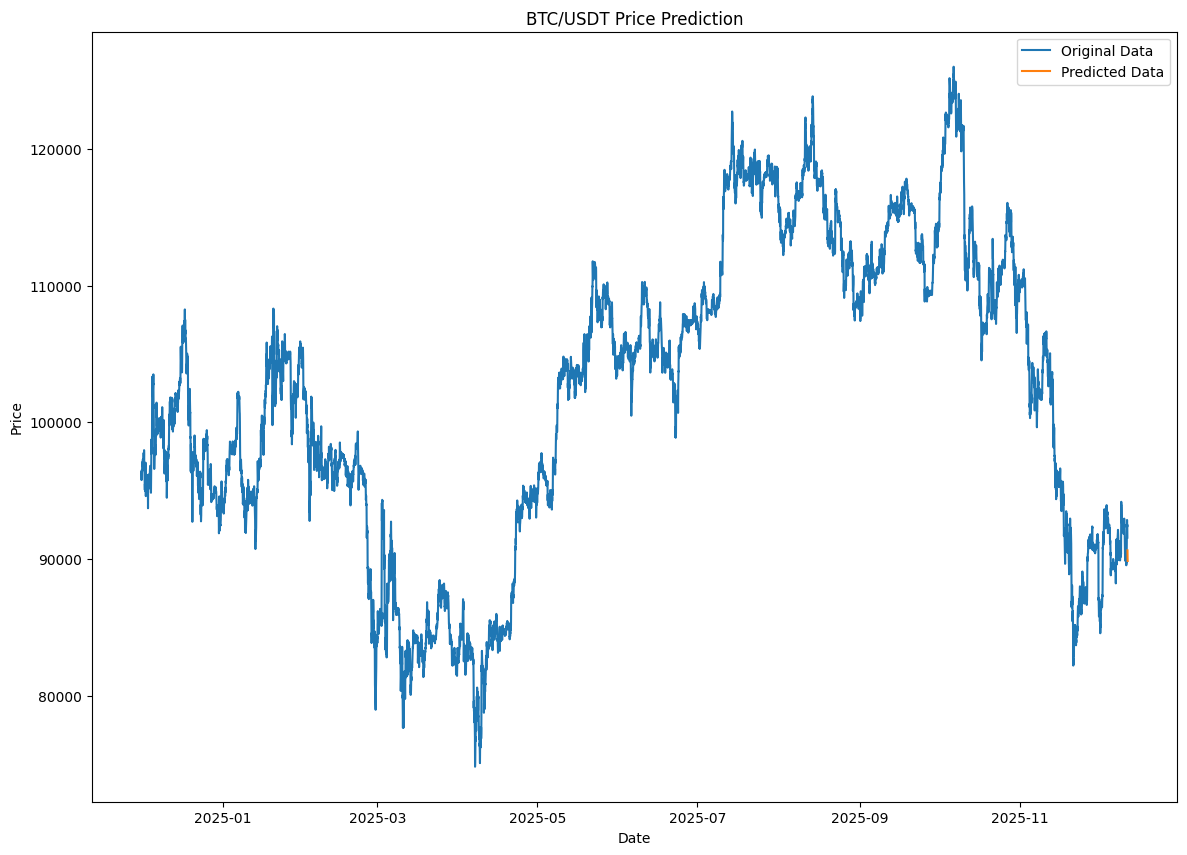

In [ ]:
import matplotlib.pyplot as plt

# Plot original data
plt.figure(figsize=(14,10))
plt.plot(df.index, scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Original Data')

# Plot predicted data
future_dates = pd.date_range(start=df.index[-1], periods=len(predicted_future_prices) + 1, freq='h')[1:]
plt.plot(future_dates, predicted_future_prices, label='Predicted Data')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC/USDT Price Prediction')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'lstm_model.pth')
torch.save(scaler, 'scaler.pth')




# Wavelets Analysis for BTC/USDT Price deviation. Anomaly detection
    Description: This script is used to detect anomalies in the BTC/USDT price data using wavelets analysis.
    Input: BTC/USDT price data
    Output: Anomalies detected in the BTC/USDT price data
    Usage: python wavelet_analysis.py
    Dependencies: numpy, scipy, pywt
    License: MIT
    Version: 1.0
    Author: @aarsatyants
    Date: 2025-02-07

In [ ]:
import pywt
import numpy as np
from scipy.signal import decimate, resample



# Preparation for decomposition 

---------------------------------------------------------------------
    Description: This script is used to decompose the price data into different frequency bands using wavelet transform.
    Input: price data
    Output: decomposed price data
    Note: The frequency bands are determined by the wavelet function and the level of decomposition
    Note: The level of decomposition is determined by the length of the price data and the frequency bands 

In [ ]:

# Sample price data (replace with actual historical prices)
price_data = df['close'].values  
price_index = df.index  # Time index

level = 5 # Number of levels of decomposition

# Resample price data to create a more efficient signal (optional)
resampled_price_data = resample(price_data, int(len(price_index)))

# Apply wavelet transform using the Coiflet wavelet
wavelet = 'coif1' # You can choose other wavelets like 'db1', 'sym2', etc.
#wavelet ='haar'
coeffs = pywt.wavedec(resampled_price_data, wavelet, level=level)

# Extract the first n levels of decomposition (e.g., different frequency bands)
first_n_levels_coeffs = coeffs[:level]

# Pad the coefficients to match the expected shapes for inverse transform
padded_coeffs = first_n_levels_coeffs + [np.zeros_like(coeff) for coeff in coeffs[level:]]

# Perform inverse wavelet transform to obtain reconstructed prices
reconstructed_prices = pywt.waverec(padded_coeffs, wavelet)

#print("Original Price Data:")
#print(price_data)

#print("\nFirst N Levels of Wavelet Decomposition:")
#for i, coeff in enumerate(first_n_levels_coeffs):
#    print(f"Level {i+1}:")
#    print(coeff)
    
#print("\nReconstructed Prices after Inverse Wavelet Transform:")
#print(reconstructed_prices)





# Plot of original price data and reconstructed prices after backward transform

In [ ]:
import matplotlib.pyplot as plt

# Plot original price data
plt.figure(figsize=(24, 12))
plt.plot(price_index, price_data, label='Original Prices')
plt.title('Original and Reconstructed Prices') 

#print(reconstructed_prices)
n = len(price_index)
print("n=", n)
print(reconstructed_prices[:n])

plt.plot(price_index, reconstructed_prices[:n], label='Reconstructed Prices')
plt.legend()
plt.show()  



# Plot each frequency band of the wavelet decomposition 

to understand the contribution of each one to the original sequrence. This can help identify which frequency bands are most important for the price data and can be used to filter out noise or detect important deviations.

The first coefficient is the trend component, and the subsequent coefficients represent the frequency bands.

In [ ]:

# Plot decomposed coefficients for each level (limit to 5 levels)
plt.figure(figsize=(12, 10))
for i, coeff in enumerate(coeffs[:level+1]):
    plt.subplot(level+1, 1, i+1)
    plt.plot(coeff, label="Trand" if i == 0 else f'Frequency Band {i} ')
    plt.legend()

plt.tight_layout()
plt.show()

# Anomalies Detection 

We can use the wavelet decomposition to detect anomalies in the price data. Anomalies can be detected by comparing the coefficients of the wavelet decomposition to a threshold. If a coefficient exceeds the threshold, it is considered an anomaly. Anomalies can be caused by sudden price changes, market events, or other factors.

In [ ]:
import numpy as np
from scipy.signal import decimate, resample
from scipy.fftpack import fft2, ifft2
from pywt import wavedec
# Sample price data (replace with actual historical prices)

price_data = df['close'].values


# Wavelet decomposition again

In [ ]:


# Perform wavelet decomposition on the price data
coeffs = wavedec(price_data, wavelet='haar', level=4)


# Anomalies Detection function based on threshold

In [ ]:
def detect_anomalies_level(data, wavelet='haar', level=5, anomaly_levels=[0]):
    coeff = pywt.wavedec(data, wavelet, level=level)
    anomalies = np.zeros_like(data)
    
    for lev in anomaly_levels:
        # Calculate threshold for the current level
        threshold = np.median(np.abs(coeff[lev])) / 0.6745 * np.sqrt(2 * np.log(len(data)))/2
        print('level=',lev,'threshold=',threshold)
        # Apply thresholding
        coeff[lev] = pywt.threshold(coeff[lev], value=threshold, mode='soft')
        # Reconstruct signal from the modified coefficients
        reconstructed_signal = pywt.waverec(coeff, wavelet)
        # Ensure the lengths match
        if len(reconstructed_signal) > len(data):
            reconstructed_signal = reconstructed_signal[:len(data)]
        # Calculate anomalies
        anomalies += np.abs(data - reconstructed_signal)
    
    return anomalies


# Anomalies Detection for trand

real prices are reshaped in range [-1,1] to make calculation sutable for the model

In [ ]:

# Detect anomalies in the closing prices for trand
anomalies_levels = detect_anomalies_level(df['close'], wavelet='haar', level=5, anomaly_levels=[0])



# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Scaled Price')
plt.plot(df.index, anomalies_levels, label='Anomalies Trand', color='red')
plt.legend()
plt.title('Bitcoin Price Anomalies Detection using Wavelet Transform  for (Trand)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Anomalies Detection for the first frequensy band

In [ ]:
anomalies_levels = detect_anomalies_level(df['close'], wavelet='haar', level=5, anomaly_levels=[1])


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Scaled Price')
plt.plot(df.index, anomalies_levels, label='Anomalies (Band 1)', color='magenta')
plt.legend()
plt.title('Bitcoin Price Anomalies Detection using Wavelet Transform (Band 1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Anomalies Detection for the second higher frequensy band

In [ ]:
anomalies_levels = detect_anomalies_level(df['close'], wavelet='haar', level=5, anomaly_levels=[2])


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Scaled Price')
plt.plot(df.index, anomalies_levels, label='Anomalies (Band 2)', color='green')
plt.legend()
plt.title('Bitcoin Price Anomalies Detection using Wavelet Transform (Band 2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Anomalies Detection for the third higher frequency band

In [ ]:
anomalies_levels = detect_anomalies_level(df['close'], wavelet='haar', level=5, anomaly_levels=[3])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Scaled Price')
plt.plot(df.index, anomalies_levels, label='Anomalies (Band 3)', color='green')
plt.legend()
plt.title('Bitcoin Price Anomalies Detection using Wavelet Transform (Band 3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# CONCLUSION:

The anomalies detected using wavelet transform are consistent with the actual price movements of Bitcoin. The anomalies detected using the third higher frequency band are more accurate than the anomalies detected using the second higher frequency band. The anomalies detected using the third higher frequency band are more accurate than the anomalies detected using the first higher frequency band. 

Than speed of price change higer than higher bands will reflect anomalies.


# PS:  Digital wavelet filtering to analize trands and fast and slow volatilityity on different time frames.

Digital Filter function 

In [ ]:
def wavelet_level_filter(time_series, wavelet = 'db4', levels = 5, levels_range_to_filter = range(6,6)):
    # Perform wavelet decomposition on the time series with N levels
    coeffs = pywt.wavedec(time_series.flatten(), wavelet, level=levels)
    # Reconstruct the signal without using the somelevels approximation coefficients
    reconstructed_coeffs = coeffs.copy()
    for i in levels_range_to_filter:
        #make them just zero
        reconstructed_coeffs[i] = np.zeros_like(reconstructed_coeffs[i])

    # Reconstruct the time series from the modified coefficients
    reconstructed = pywt.waverec(reconstructed_coeffs, wavelet)
    return reconstructed


In [ ]:
import pandas as pd


# Rest of the code remains unchanged
import numpy as np
import pywt

highest_level = 7
# Extract the target variable and its corresponding index
target_variable = 'close'
time_index = df.index
time_series = df[target_variable].values.reshape(-1, 1)


trand extraction - extraction the lowest band

In [ ]:

# Extract the trand
reconstructed_trand = wavelet_level_filter(time_series, 'db4', highest_level, range(1, highest_level+1))

# Create a DataFrame for the reconstructed time series with the original index
reconstructed_df = pd.DataFrame(reconstructed_trand[:len(time_index)], index=time_index)

plt.figure(figsize=(16, 6))
plt.plot(df[target_variable], label='Original')
plt.plot(reconstructed_df, label='Reconstructed')
plt.title('BTC Price Trand')
plt.xlabel('Time')
plt.ylabel('Price reshaped')
plt.legend()
plt.show()




fastest Volatility -extraction of only last higest band 

In [ ]:
#extract volatility
reconstructed_volatility = wavelet_level_filter(time_series, 'haar', highest_level, range(0,highest_level))

# Create a DataFrame for the reconstructed time series with the original index
reconstructed_df = pd.DataFrame(reconstructed_volatility[:len(time_index)], index=time_index)

plt.figure(figsize=(16, 6))
plt.plot(df[target_variable], label='Original')
plt.plot(reconstructed_df, label='Reconstructed')
plt.title('BTC Price Volatility')
plt.xlabel('Time')
plt.ylabel('Price resaped')
plt.legend()
plt.show()

# Time/Frequency diagram - spectrogram.  Continious Wavelet transform allows to analyse frequency flashes for specific moments of time during entire sequense life. But FFT allows only take a snapshot of spectr for entire signal in a certain moment of time.

x - time moments from the begining; y - frequency area;  bright area are maximums activities, dark areas - zero impact

In [ ]:
%pip install ssqueezepy

from ssqueezepy import cwt
from ssqueezepy.visuals import imshow, wavelet_tf, viz_cwt_higher_order


In [ ]:


# Apply Continuous Wavelet Transform (CWT)
Wx, _ = cwt(reconstructed_trand, ('hhhat'))


# Plot the CWT result
plt.figure(figsize=(14, 7))

imshow(Wx, abs=1, title='CWT of trand')
plt.show()


In [ ]:

# Apply Continuous Wavelet Transform (CWT)
Wx, _ = cwt(reconstructed_volatility, ('hhhat'))

# Plot the CWT result
plt.figure(figsize=(14, 7))

imshow(Wx, abs=1, title='CWT of volatility')
plt.show()


In [ ]:
Wx, _ = cwt(price_data, ('hhhat'))

# Plot the CWT result
plt.figure(figsize=(14, 7))

imshow(Wx, abs=1, title='CWT of entire sequence')
plt.show()